## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [44]:
# load in packages
from itertools import combinations

from test_results import valid_results, test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

ID Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0   1        No         0   2  30.443518 -1.165083   1   1   3   2
1   3        No         0   3  32.159350 -0.645617   2   3   2   2
2   4        No         0   2  30.431659  0.133583   1   1   4   2
3   5        No         0   0  26.588914 -0.212728   2   1   4   2
4   8       Yes         0   3  28.044332 -0.385883   1   1   2   2

In [3]:
test_data = pd.read_csv('./Test.csv')
test_data.head()

ID Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0   2        No         0   1  41.376390  1.172517   1   1   2   2
1   6       Yes         0   1  25.163598  0.653050   2   2   2   2
2   7       Yes         0   1  26.553778 -1.597972   2   3   4   2
3  10        No         0   2  28.529691 -1.078506   2   3   2   2
4  12        No         0   2  32.378538  0.479895   2   2   1   2

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41650 entries, 0 to 41649
Data columns (total 10 columns):
ID           41650 non-null int64
Promotion    41650 non-null object
purchase     41650 non-null int64
V1           41650 non-null int64
V2           41650 non-null float64
V3           41650 non-null float64
V4           41650 non-null int64
V5           41650 non-null int64
V6           41650 non-null int64
V7           41650 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 3.2+ MB


# TBD: Do an a/b test assessment
Just need p-value, or also consider statistical power?

# Build model with transformed target
Single-model approach, either using encoding used here, or one read about in paper. May actually be good to compare them.

In [6]:
train_data['Promotion'].value_counts()
# Yes    42364
# No     42170

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [7]:
train_data['purchase'].value_counts()
# 0    83494
# 1     1040

0    83494
1     1040
Name: purchase, dtype: int64

In [8]:
train_data['Promotion'].str.match('Yes')

0        False
1        False
2        False
3        False
4         True
         ...  
84529    False
84530     True
84531    False
84532    False
84533    False
Name: Promotion, Length: 84534, dtype: bool

Make transformed target for training data

In [9]:
train_data['target'] = train_data['Promotion'].str.match('Yes') & train_data['purchase'].astype('bool')

# train_data['target'] = (train_data['Promotion'].str.match('Yes') & train_data['purchase'].astype('bool'))\
#     | (train_data['Promotion'].str.match('No') & train_data['purchase']==0)

train_data['target'] = train_data['target'].astype('bool')

In [10]:
train_data['target'].value_counts()
# False    83813
# True       721

False    83813
True       721
Name: target, dtype: int64

In [11]:
train_data['target'].sum()
# 721

721

In [12]:
# split training data into train and validation
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

Downsample training data for balanced classes

https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas

In [13]:
train['target'].value_counts()
# False    67047
# True       580

False    67047
True       580
Name: target, dtype: int64

In [14]:
downsampled_train = \
train.groupby('target', group_keys=False).apply(lambda x: x.sample(train['target'].sum(), random_state=1))

In [15]:
downsampled_train.shape
# (1160, 11)

(1160, 11)

In [16]:
type(downsampled_train)

pandas.core.frame.DataFrame

In [17]:
downsampled_train['target'].value_counts()
# True     580
# False    580

True     580
False    580
Name: target, dtype: int64

### Train XGBoost

In [18]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [69]:
X_train_downsamp = downsampled_train[features]
y_train_downsamp = downsampled_train['target']
X_valid = valid[features]
y_valid = valid['target']

In [70]:
eval_set = [(X_train_downsamp, y_train_downsamp), (X_valid, y_valid)]

In [71]:
# Train an xgboost model
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 7,
                          min_child_weight = 5,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

In [72]:
%%time
model.fit(X_train_downsamp, y_train_downsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.740039	validation_1-auc:0.609996
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.751833	validation_1-auc:0.625492
[2]	validation_0-auc:0.756189	validation_1-auc:0.629561
[3]	validation_0-auc:0.758218	validation_1-auc:0.629651
[4]	validation_0-auc:0.764927	validation_1-auc:0.631139
[5]	validation_0-auc:0.771283	validation_1-auc:0.632887
[6]	validation_0-auc:0.773246	validation_1-auc:0.635403
[7]	validation_0-auc:0.774764	validation_1-auc:0.638418
[8]	validation_0-auc:0.775724	validation_1-auc:0.638948
[9]	validation_0-auc:0.780788	validation_1-auc:0.638842
[10]	validation_0-auc:0.783239	validation_1-auc:0.638794
[11]	validation_0-auc:0.788429	validation_1-auc:0.642171
[12]	validation_0-auc:0.789997	validation_1-auc:0.641225
[13]	validation_0-auc:0.793078	validation_1-auc:0.639637
[14]	validation_0-auc:0.795525	validation_1-auc:0.64065

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

Results from running at home:
```
Stopping. Best iteration:
[11]	validation_0-auc:0.788429	validation_1-auc:0.642171

CPU times: user 632 ms, sys: 29.7 ms, total: 661 ms
Wall time: 384 ms
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)
```

Identical results, running in the office.

# Assess models
Use deciles and Qini curve.
- Compare downsampling versus SMOTE, and two different ways of encoding the response
- May also want to do Incremental Revenue analysis for monetary impact

Gutierrez and and Gerardy 2016:

>A common approach to evaluate an uplift model is to first predict uplift for both treated and control observations and compute the average prediction per decile in both groups. Then, the difference between those averages is taken for each decile. This difference thus gives an idea of the uplift gain per decile.

Break this procedure down in to chunks. First,

> predict uplift for both treated and control observations

Do this for the validation set.

Get uplift prediction for all observations

In [73]:
# #Peak at test set
# X_valid = test_data[features]

(array([ 731., 1248., 1984., 2305., 1922., 2370., 2119., 1953., 1332.,
         943.]),
 array([0.20156759, 0.2541693 , 0.30677098, 0.35937268, 0.41197437,
        0.46457607, 0.51717776, 0.56977946, 0.62238115, 0.67498285,
        0.72758454], dtype=float32),
 <a list of 10 Patch objects>)

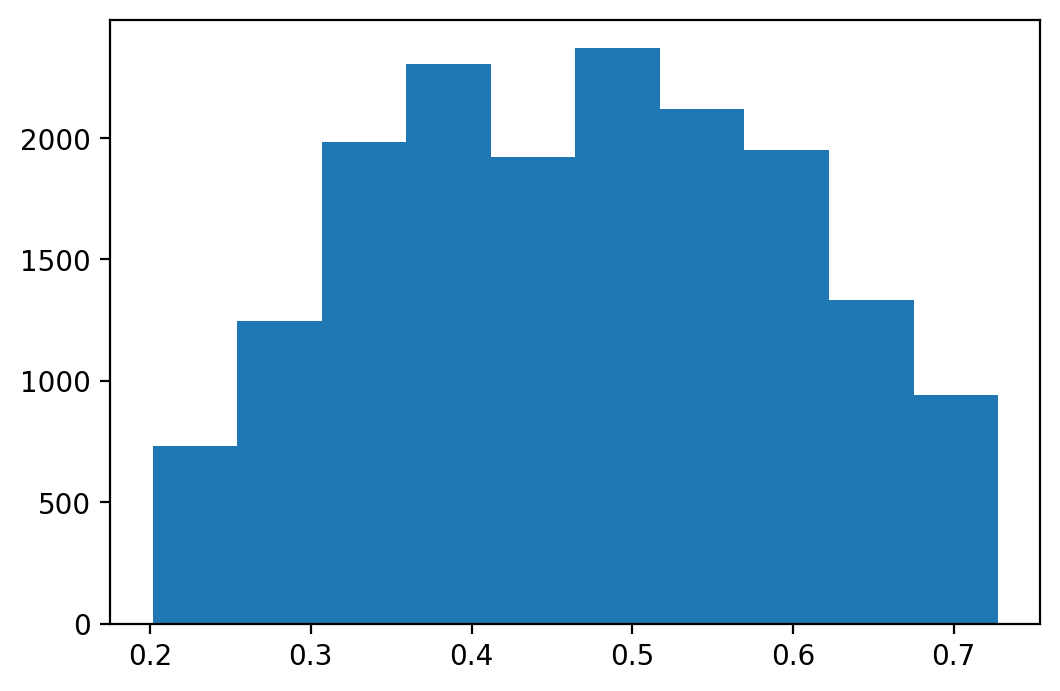

In [74]:
valid_predict_proba = model.predict_proba(X_valid)[:,1]
plt.hist(valid_predict_proba)

> compute the average prediction per decile in both groups

Need to compute deciles for each group separately, then get the mean model prediction within these groups.

I think this is actually a typo in the paper, as this would be characterizing the scores within difference deciles of scores, notwithstanding the success of the campaign (`purchase`). Rather, I think it should be to "compute the average success, per decile of predicted success, in both groups.

In [75]:
valid_predict_proba.shape

(16907,)

In [76]:
valid.shape

(16907, 11)

In [77]:
# test_data.shape

Create a new datafrmae from the validation df, to add the uplift scores and deciles to.

In [78]:
# valid_w_score = test_data.copy()
valid_w_score = valid.copy()
valid_w_score['Uplift score'] = valid_predict_proba

In [79]:
valid_w_score['Promotion'].value_counts()
# No     8474
# Yes    8433

No     8474
Yes    8433
Name: Promotion, dtype: int64

In [80]:
validation_treatment_mask = valid_w_score['Promotion'].str.match('Yes')

Make labels for the deciles, which will be done separately for uplift model socres in treatment and control groups.

In [81]:
decile_labels = [number for number in range(1,11)]
print(decile_labels)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Pandas has a convenient function to produce a series of labels according to which quantile an observation in the input series belongs to. Get the series for treatment and control separately.

In [82]:
treatment_score_deciles, treatment_score_decile_bins = \
pd.qcut(x=valid_w_score.loc[validation_treatment_mask, 'Uplift score'],
        q=10,
        labels=decile_labels,
        retbins=True)

control_score_deciles, control_score_decile_bins = \
pd.qcut(x=valid_w_score.loc[~validation_treatment_mask, 'Uplift score'],
        q=10,
        labels=decile_labels,
        retbins=True)

Here are the quantile labels (not differentiable between treatment and control in this output):

In [83]:
treatment_score_deciles.head()

6264      8
24896     4
45830     3
61302     3
60120    10
Name: Uplift score, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

The bin edges for treatment:

In [84]:
treatment_score_decile_bins

array([0.20156759, 0.2947042 , 0.3506009 , 0.38802063, 0.42448917,
       0.47076094, 0.50762457, 0.55289088, 0.59514534, 0.64623296,
       0.72758454])

And control:

In [85]:
control_score_decile_bins

array([0.20156759, 0.28893906, 0.34806499, 0.3860929 , 0.42412701,
       0.46831059, 0.50348922, 0.55160415, 0.59508085, 0.64223218,
       0.72758454])

These are very similar, which seems good. Create a new column for these decile labels to go with the validation set.

In [86]:
valid_w_score['Decile bin'] = np.nan

Put in the decile labels separately for treatment and control groups.

In [87]:
valid_w_score.loc[validation_treatment_mask, 'Decile bin'] = treatment_score_deciles
valid_w_score.loc[~validation_treatment_mask, 'Decile bin'] = control_score_deciles

In [88]:
valid_w_score[['Promotion', 'Decile bin', 'Uplift score', 'purchase']].head(10)

Promotion  Decile bin  Uplift score  purchase
6264        Yes           8      0.557656         0
41822        No           9      0.618133         0
8569         No           6      0.501890         0
41228        No           7      0.523865         0
24896       Yes           4      0.413907         0
45830       Yes           3      0.356000         0
61302       Yes           3      0.386093         0
60120       Yes          10      0.661588         0
75899        No           6      0.500598         0
67557        No           2      0.340484         0

Now do a groupby/mean of the purchase occurrence to get the rate of purchase within each decile for treatment and control groups.

In [89]:
mean_response_treatment = \
valid_w_score.loc[validation_treatment_mask,:]\
.groupby('Decile bin')\
['purchase'].mean()

In [90]:
mean_response_control = \
valid_w_score.loc[~validation_treatment_mask,:]\
.groupby('Decile bin')\
['purchase'].mean()

> the difference between those averages is taken for each decile

Finally calculate the lift by subtracting these.

In [91]:
lift = mean_response_treatment - mean_response_control
lift

Decile bin
1    -0.005878
2    -0.002283
3    -0.000096
4     0.002460
5     0.016781
6     0.010107
7     0.011689
8     0.005895
9     0.022502
10    0.027454
Name: purchase, dtype: float64

Text(0.5, 1.0, 'Difference in purchase rate\nbetween uplift score deciles of treatment and control group')

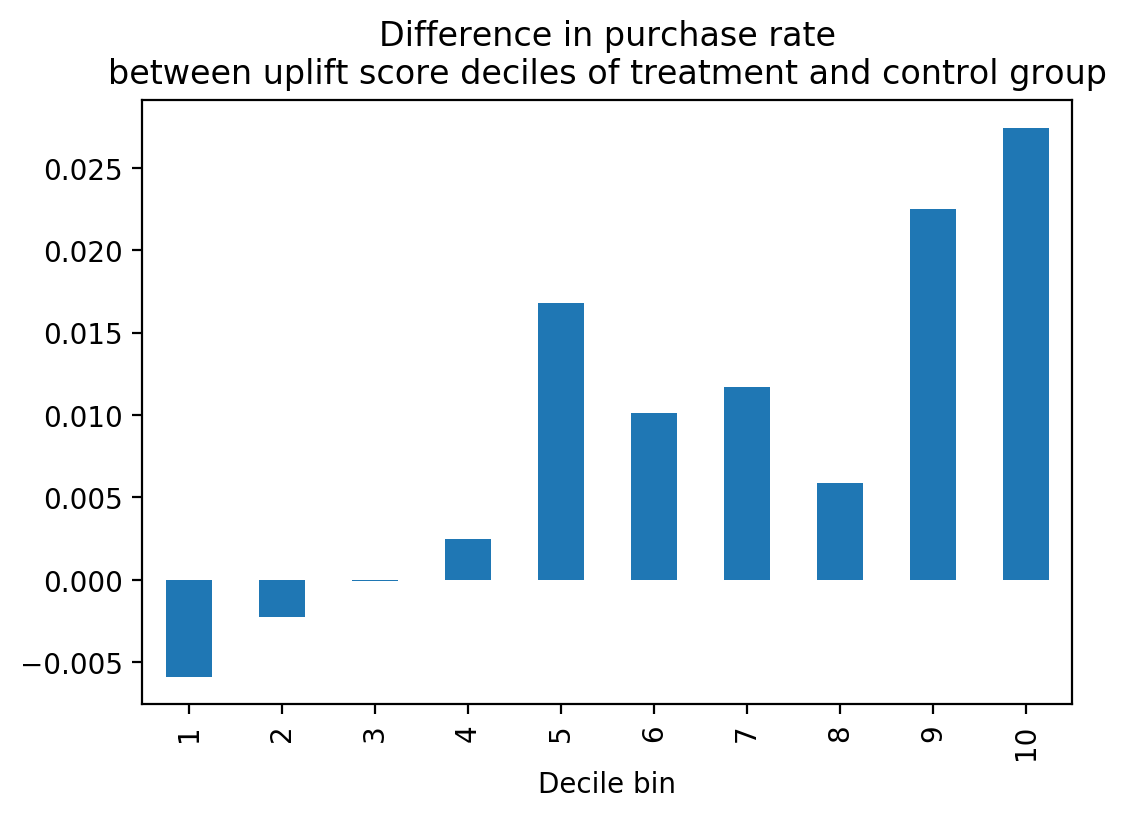

In [92]:
mpl.rcParams['figure.dpi'] = 200
lift.plot.bar()
plt.title('Difference in purchase rate\nbetween uplift score deciles of treatment and control group')

The lifts in these various deciles would, I think, be compared to the difference in purchase rates between all people who got the promotion and all who didn't, which would be the result of randomly offering the promotion to everyone.

In [93]:
purchase_rate_by_promotion = valid.groupby('Promotion')['purchase'].mean()
purchase_rate_by_promotion

Promotion
No     0.007907
Yes    0.016720
Name: purchase, dtype: float64

In [94]:
purchase_rate_by_promotion[1] - purchase_rate_by_promotion[0]

0.00881349081506308

A cumulative curve, as described in the reference, seems like a good way to get at how much lift would be obtained by targeting people starting with the highest lift scores and proceeding down. Layering on a financial component to this would be great.

# TBD: Variable selection using modified NIV

# TBD: Two model approach